In [1]:
import math
import joblib
import tf_keras as keras

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tf_keras import activations, layers, initializers
from tf_keras.models import Model
import tensorflow_probability as tfp

from tqdm import tqdm
from matplotlib import pyplot as plt

tfd = tfp.distributions
tfb = tfp.bijectors
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)

TFP Version 0.25.0
TF  Version 2.18.0


In [2]:
u_in = np.load("data/poisson1Dinput.npy")
g_uy_out = np.load("data/poisson1Doutput.npy") * 20

In [3]:
u_in = np.expand_dims(u_in, axis=1)
g_uy_out = np.expand_dims(g_uy_out, axis=-1)

In [4]:
u_in.shape

(2000, 1, 100)

In [5]:
n_total = 1000
n_test = 400
rand = 42
u_in_use, g_uy_out_use = u_in[:n_total,...], g_uy_out[:n_total,...]

idxs = np.arange(u_in_use.shape[0])
idx_train, idx_test = train_test_split(idxs, test_size=n_test/n_total, 
                                        random_state=rand)

u_train, g_train = u_in_use[idx_train,:], g_uy_out_use[idx_train,:]
u_test, g_test = u_in_use[idx_test,:], g_uy_out_use[idx_test,:]

n_grid = 100
y_space_train = np.expand_dims(np.tile(np.linspace(0,1,n_grid),(u_train.shape[0],1)), axis=-1)
y_space_test = np.expand_dims(np.tile(np.linspace(0,1,n_grid),(u_test.shape[0],1)), axis=-1)

In [6]:
u_train.shape

(600, 1, 100)

In [20]:
y_space_train.shape

(600, 100, 1)

In [21]:
g_train.shape

(600, 100, 1)

In [7]:
def build_mlp(inputs, output_features: int,
              hidden_features: int, num_hidden_layers: int, modelname="Trunk"):
    """
    Builds an MLP regression model.
    
    Parameters:
        x: Input tensor.
        output_features (int): Number of output features.
        hidden_features (int): Number of units in each hidden layer.
        num_hidden_layers (int): Number of hidden layers.
    
    Returns:
        array: keras tensor.
    """
    x = inputs
    kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (600 * 1.0)
    bias_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (600 * 1.0)
    
    # Create hidden layers with tanh activation
    for ii in range(num_hidden_layers):
        x = tfp.layers.DenseFlipout(hidden_features, bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn, activation='relu', name=f"Hidden_{modelname}_{ii}")(x)
    
    # Output layer with linear activation for regression
    outputs = tfp.layers.DenseFlipout(output_features, activation='relu', name=f"Out_{modelname}_{ii}")(x)
    
    return outputs

In [8]:
def normal_sp(params):
    return tfd.Normal(loc = params[:,:,0:1], scale = 0.001+tf.math.softplus(0.05 * params[:,:,1:2]))    

def NLL(y, distr): 
  return -distr.log_prob(y) 

In [9]:
def fn(x):
    y = tf.einsum("ij, ij->i", x[0], x[1])
    y = tf.expand_dims(y, axis = 1)
    return y

def deeponet(y_in_size, u_in_size, trunk_params, branch_params, out_feat=1):
    """_summary_

    Args:
        y_in_size (tuple): spatial input size
        u_in_size (tuple): function input size
        trunk_params (dict): trunk net parameters
        branch_params (dict): branch net parameters
        out_feat (int, optional): number of output feature. Defaults to 1.

    Returns:
        keras.Model: output model
    """
    y_input = layers.Input(y_in_size, name="Input_Trunk")
    u_input = layers.Input(u_in_size, name="Input_Branch")

    # Trunk layer
    trunk_out = build_mlp(y_input, trunk_params["output_features"],
                          trunk_params["hidden_features"], trunk_params["num_hidden_layers"], modelname="Trunk")
    
    # Branch layer
    branch_out = build_mlp(u_input, branch_params["output_features"], 
                          branch_params["hidden_features"], branch_params["num_hidden_layers"], modelname="Branch")

    # Multiply trunk and branch
    mult_out = layers.Dot(axes=-1)([trunk_out, branch_out])
    out = tfp.layers.DenseFlipout(2)(mult_out)

    dist = tfp.layers.DistributionLambda(normal_sp)(out)

    model = Model(inputs=[y_input, u_input], outputs=dist, name="VB-DeepONet")

    return model


In [10]:
trunk_params=dict()
trunk_params["output_features"] = 32
trunk_params["hidden_features"] = 32
trunk_params["num_hidden_layers"] = 3

branch_params=dict()
branch_params["output_features"] = 32
branch_params["hidden_features"] = 32
branch_params["num_hidden_layers"] = 3

In [11]:
onet = deeponet(y_in_size=(100,1), u_in_size=(1,100), trunk_params=trunk_params, 
                branch_params=branch_params, out_feat=1)
onet.summary()

/Users/fazaghifari/miniconda3/envs/tfprobenv/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:99: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/Users/fazaghifari/miniconda3/envs/tfprobenv/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:109: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(
/Users/fazaghifari/miniconda3/envs/tfprobenv/lib/python3.9/site-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than

Model: "VB-DeepONet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input_Trunk (InputLayer)    [(None, 100, 1)]             0         []                            
                                                                                                  
 Input_Branch (InputLayer)   [(None, 1, 100)]             0         []                            
                                                                                                  
 Hidden_Trunk_0 (DenseFlipo  (None, 100, 32)              128       ['Input_Trunk[0][0]']         
 ut)                                                                                              
                                                                                                  
 Hidden_Branch_0 (DenseFlip  (None, 1, 32)                6464      ['Input_Branch[0][0]

In [12]:
onet.compile(
    optimizer=keras.optimizers.legacy.Adam(learning_rate=1e-3),
    loss=NLL,
    metrics=["mse"]
)

In [13]:
history = onet.fit(x=[y_space_train,u_train], y=g_train, batch_size=256, epochs=2000, verbose=1)

Epoch 1/2000
3/3 [==============================] - 2s 25ms/step - loss: 5223.5688 - mse: 1.6457
Epoch 2/2000
3/3 [==============================] - 0s 22ms/step - loss: 5217.0469 - mse: 1.6233
Epoch 3/2000
3/3 [==============================] - 0s 23ms/step - loss: 5210.5464 - mse: 1.6210
Epoch 4/2000
3/3 [==============================] - 0s 24ms/step - loss: 5204.0669 - mse: 1.6143
Epoch 5/2000
3/3 [==============================] - 0s 24ms/step - loss: 5197.6064 - mse: 1.6072
Epoch 6/2000
3/3 [==============================] - 0s 23ms/step - loss: 5191.1631 - mse: 1.5862
Epoch 7/2000
3/3 [==============================] - 0s 24ms/step - loss: 5184.7402 - mse: 1.5858
Epoch 8/2000
3/3 [==============================] - 0s 22ms/step - loss: 5178.3325 - mse: 1.5786
Epoch 9/2000
3/3 [==============================] - 0s 27ms/step - loss: 5171.9390 - mse: 1.5718
Epoch 10/2000
3/3 [==============================] - 0s 24ms/step - loss: 5165.5562 - mse: 1.5424
Epoch 11/2000
3/3 [==========

In [14]:
pred_list = []

for i in tqdm(range(100)):
    preds = onet.predict([y_space_test, u_test], verbose=0)
    pred_list.append(preds)

100%|██████████| 100/100 [00:13<00:00,  7.65it/s]


In [15]:
y_preds = np.concatenate(pred_list, axis=-1)

y_mean = np.mean(y_preds, axis=-1)
y_sigma = np.std(y_preds, axis=-1)

In [16]:
y_mean.shape

(400, 100)

In [17]:
g_train.shape

(600, 100, 1)

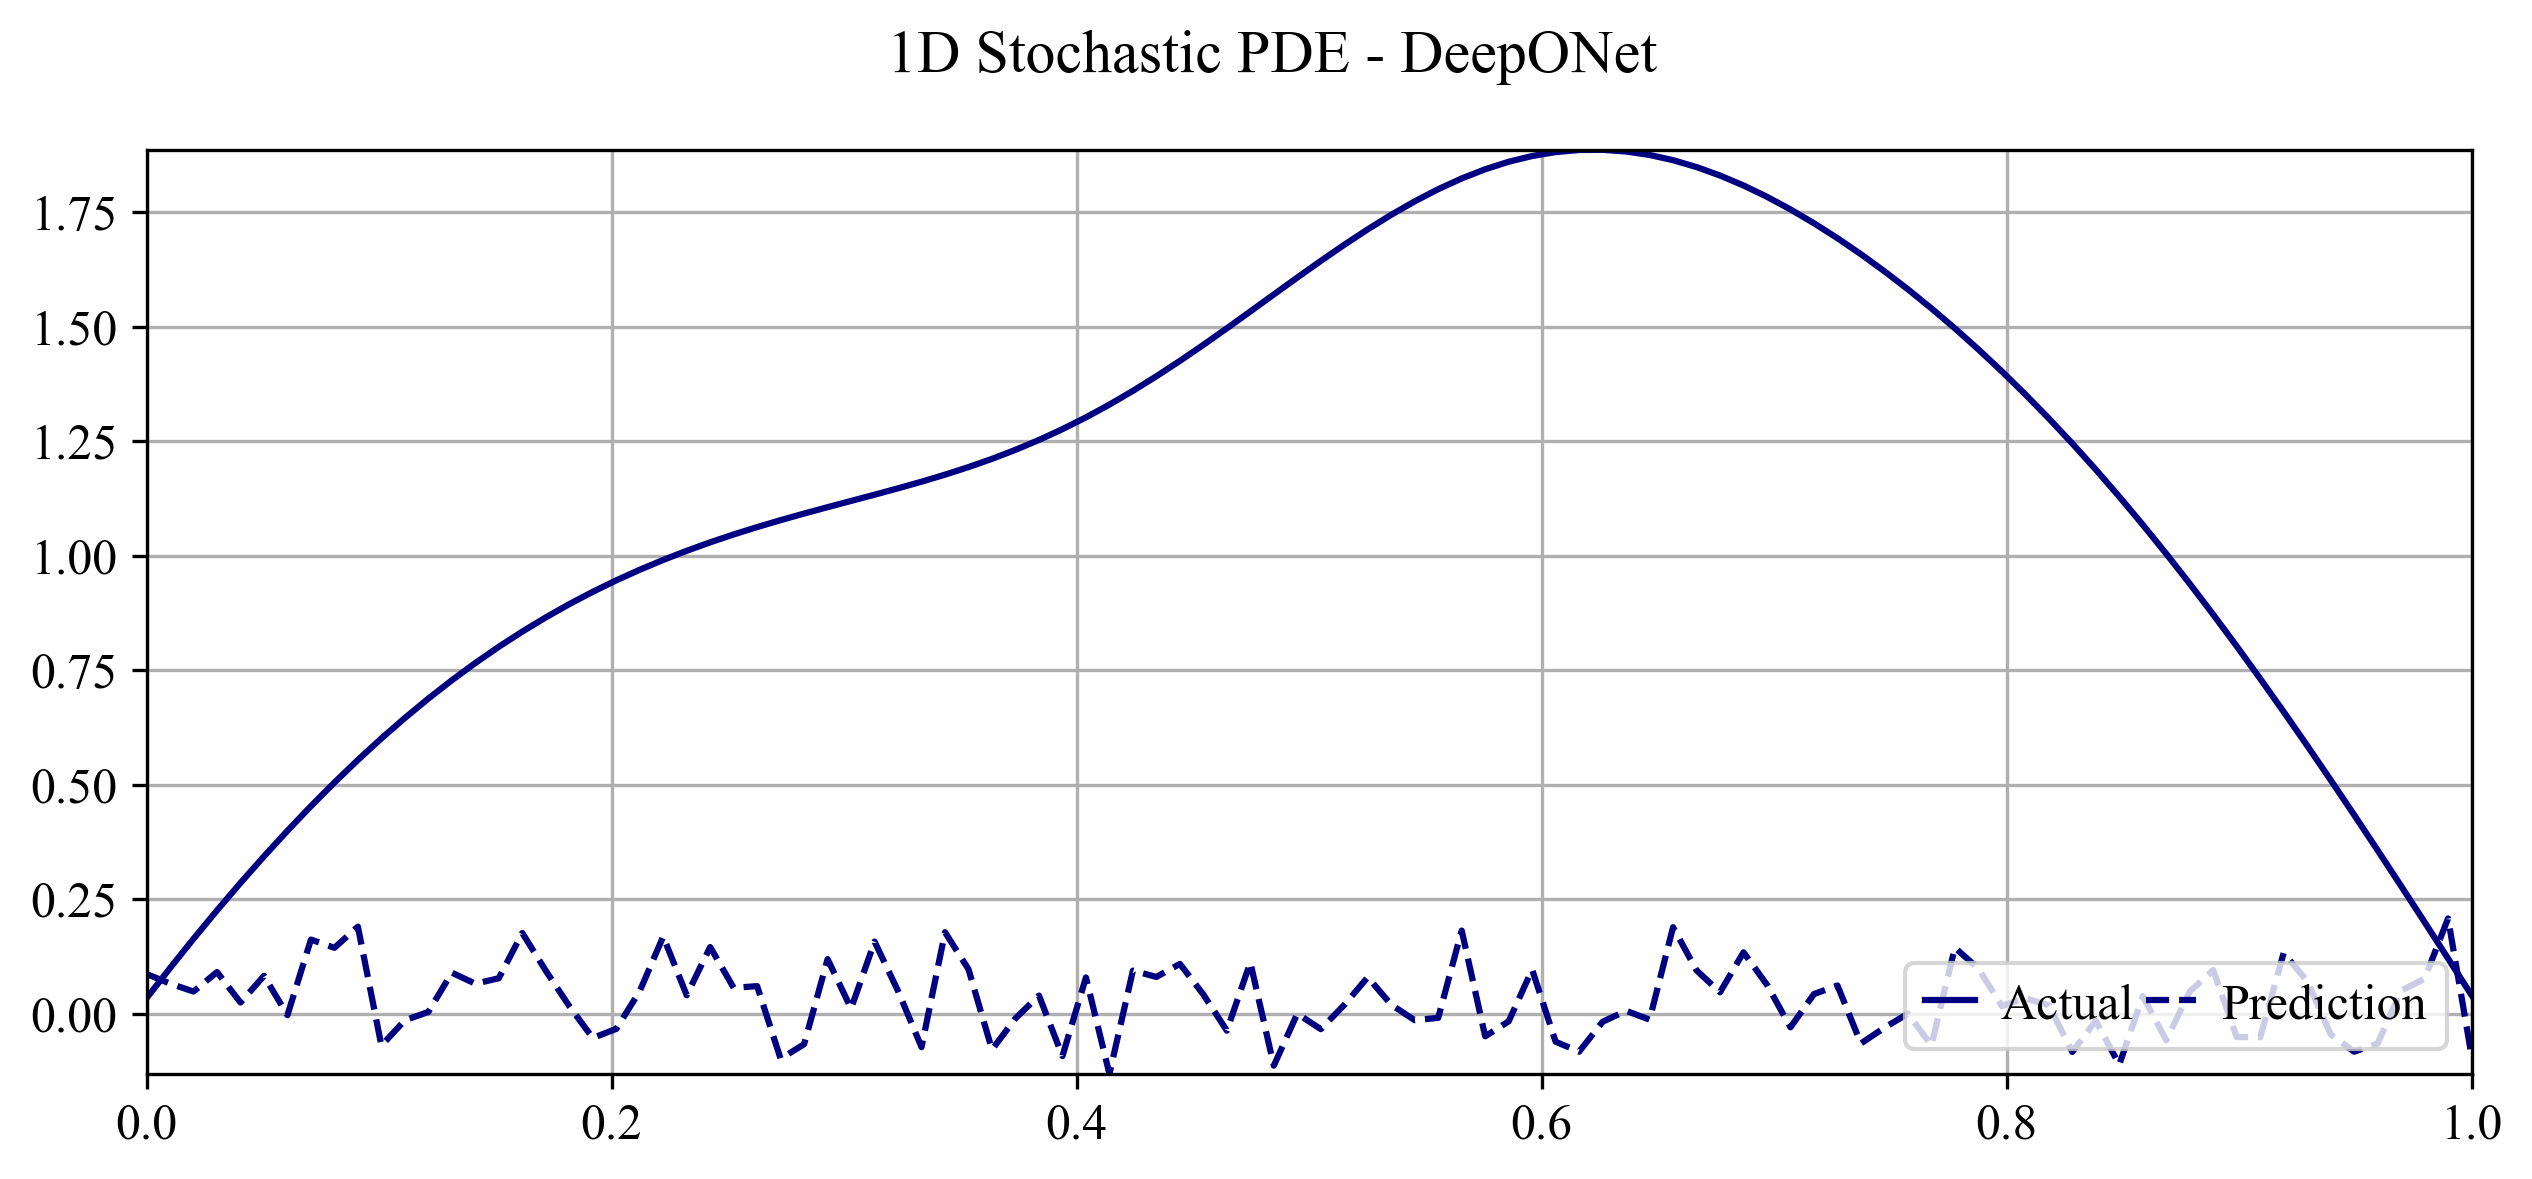

In [18]:
plt.rcParams['font.family'] = 'Times New Roman' 
plt.rcParams['font.size'] = 12
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

colormap = plt.cm.jet  
colors = [colormap(i) for i in np.linspace(0, 1, 5)]

fig2 = plt.figure(figsize = (10, 4), dpi=300)
fig2.suptitle('1D Stochastic PDE - DeepONet')

index = 0
for i in [7]:
    plt.plot(y_space_test[0,:,0], g_test[i, :], color=colors[index], label='Actual')
    plt.plot(y_space_test[0,:,0], y_mean[i,:], '--', color=colors[index], label='Prediction')
    index += 1
plt.legend(ncol=4, loc=4, labelspacing=0.25, columnspacing=0.25, handletextpad=0.5, handlelength=1)
plt.grid(True)
plt.margins(0)